## ToDo

- Clean datasets:
    - If opening price jump too much (like 100 times) intra-day, remove data point.

In [185]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import empyrical
import datetime
import pandas as pd
from backtrader.utils.py3 import iteritems
import pdb
import pyfolio as pf
import decimal
import numpy as np
import math

import matplotlib
%matplotlib inline

In [186]:
def get_data_feed_by_name(data_feed_name, start, end):
    return bt.feeds.YahooFinanceData(dataname=data_feed_name,period='d', fromdate=start,
                                todate=end)

def get_local_data_feed_by_name(data_filename,start,end):
    return bt.feeds.YahooFinanceCSVData(
        dataname=data_filename,
        # Do not pass values before this date
        fromdate=start,
        # Do not pass values after this date
        todate=end,
        reverse=False)

In [285]:
start=datetime.datetime(2019,10,1)
end=datetime.datetime(2020,7,30)

data_vusa_csv = get_local_data_feed_by_name('VUSA.DE.csv',start,end)
data_stoxx_csv = get_local_data_feed_by_name('EXSA.DE.csv',start,end)
data_em_csv = get_local_data_feed_by_name('IS3N.DE.csv',start,end)
data_tech_csv = get_local_data_feed_by_name('QDVE.DE.csv',start,end)
data_japan_csv = get_local_data_feed_by_name('EUNN.DE.csv',start,end)
data_bonds_csv = get_local_data_feed_by_name('AGGH.MI.csv',start,end)
data_pacific_csv = get_local_data_feed_by_name('VGEK.DE.csv',start,end)
data_china_csv = get_local_data_feed_by_name('ICGA.DE.csv',start,end)
data_nasdaq100_csv = get_local_data_feed_by_name('EXXT.DE.csv',start,end)

In [286]:
etf_allocation_csv = {'stoxx':(data_stoxx_csv,0.24),
                     'nasdaq100':(data_nasdaq100_csv,0.24),
                     'emerging_markets':(data_em_csv,0.24),
                     'china':(data_china_csv,0.04),
                     'pacific':(data_pacific_csv,0.035),
                     'bonds':(data_bonds_csv,0.05),
                     'japan':(data_japan_csv,0.04), 
                     'tech':(data_tech_csv,0.10)
                     }
                 
print (sum([v[1] for k,v in etf_allocation_csv.items()]))

0.985


In [287]:
class BuyAndHold_More_Fund_2Stocks(bt.Strategy):
    #params = dict(monthly_cash=1000.0)
    
    params = (
        ('etf_allocation',{}),
        ('monthly_cash',1000),
        )
    
    def __init__(self):
        self.etf_allocation = self.params.etf_allocation
        self.log('etf alloc {}'.format(self.etf_allocation))
        self.target_value = 0.
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def start(self):
        # Activate the fund mode and set the default value at 100
        self.broker.set_fundmode(fundmode=True, fundstartval=100.00)
        self.cash_start = self.broker.get_cash()
        self.val_start = 100.0
        self.add_timer(
            bt.timer.SESSION_END, monthdays=[1], monthcarry=True)
        
    def next_open(self):
        # order to buy at open price
        if self.execute_order:
        
            for data_name,(data_feed,percent_allocation) in self.etf_allocation.items():
                #print ('data_name {}'.format(data_name))
                next_open_price = data_feed.open[0]+1e-6
                size = self.target_value*percent_allocation/next_open_price
                #self.log('order executed by next_open, open {}'.format(self.datas[0].open[0]))
                order = self.buy(data=data_feed,size=size)
            
            self.execute_order = False
        
    def notify_timer(self, timer, when, *args, **kwargs):
        # Add the influx of monthly cash to the broker
        self.broker.add_cash(self.p.monthly_cash)                
        target_value = self.broker.getcash() + self.p.monthly_cash
        
        # Order will be executed at next_open
        self.execute_order = True
        self.target_value = target_value
            
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1.0
        self.froi = self.broker.get_fundvalue() - self.val_start
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value: {:.2f}%'.format(self.froi))

In [288]:
# Running
cerebro = bt.Cerebro(cheat_on_open=True)
cerebro.broker.set_cash(0.000001)
cerebro.broker.set_fundmode(True)

#cerebro.adddata(data_vusa_csv)
#cerebro.adddata(data_stoxx_csv)

allocation = etf_allocation_csv

for data_name,(data_feed,percent_allocation) in allocation.items():
    cerebro.adddata(data_feed, name=data_name)


#cerebro.addstrategy(BuyAndHold_More_Fund_2Stocks, period=14)
cerebro.addstrategy(BuyAndHold_More_Fund_2Stocks,etf_allocation=allocation, monthly_cash=700)

# Observers
cerebro.addobserver(bt.observers.TimeReturn, timeframe=bt.TimeFrame.Days)

# Analyzers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.PositionsValue, headers=True, cash=True, _name='mypositions')
cerebro.addanalyzer(bt.analyzers.TimeReturn,_name='timereturn')
    
# Execute

results = cerebro.run()

# ToDo - sizer?

2020-07-24, etf alloc {'bonds': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa300c90588>, 0.05), 'japan': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa2fda68b70>, 0.04), 'emerging_markets': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa2fda688d0>, 0.24), 'pacific': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa300c90ef0>, 0.035), 'nasdaq100': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa300f18828>, 0.24), 'tech': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa2fda68160>, 0.1), 'china': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa300f18630>, 0.04), 'stoxx': (<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7fa300f7bdd8>, 0.24)}
ROI:        735297426119.11%
Fund Value: 6.27%


In [289]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio',)
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items() #<--positions only holds data for one symbol here

In [290]:
transactions.head(8)

,amount,price,sid,symbol,value
date,,,,,
2019-10-02 23:59:59.999989+00:00,6.679388,5.24,0,bonds,-34.999993
2019-10-02 23:59:59.999989+00:00,0.731070,38.30,1,japan,-27.999999
2019-10-02 23:59:59.999989+00:00,6.865549,24.47,2,emerging_markets,-167.999993
2019-10-02 23:59:59.999989+00:00,1.006987,24.33,3,pacific,-24.499999
2019-10-02 23:59:59.999989+00:00,2.456499,68.39,4,nasdaq100,-167.999998
2019-10-02 23:59:59.999989+00:00,7.700769,9.09,5,tech,-69.999992
2019-10-02 23:59:59.999989+00:00,6.167400,4.54,6,china,-27.999994
2019-10-02 23:59:59.999989+00:00,4.433887,37.89,7,stoxx,-167.999996


## Analysis

In [291]:
strat = results[0]
timereturn_analyzer = strat.analyzers.getbyname('timereturn')
timereturn = timereturn_analyzer.get_analysis()

p = strat.analyzers.getbyname('mypositions').get_analysis()
mypositions = [[k] + v for k, v in iteritems(p)] #<-- Now positions will hold data for all symbols
cols = mypositions.pop(0)  # headers are in the first entry
mypositions = pd.DataFrame.from_records(mypositions, index=cols[0], columns=cols)
mypositions.index = pd.DatetimeIndex(mypositions.index) 

In [292]:
mypositions['total'] = mypositions.sum(axis=1)
myreturns = mypositions['total'].pct_change()
myreturns.index = pd.to_datetime(myreturns.index).tz_localize('US/Eastern')

In [293]:
timereturn_df = pd.DataFrame([(k,v) for k,v in timereturn.items()],columns=['date','return'])
timereturn_df.set_index('date',inplace=True)
timereturn.index = pd.to_datetime(timereturn_df.index)

Stress Events,mean,min,max
New Normal,0.04%,-9.49%,5.06%


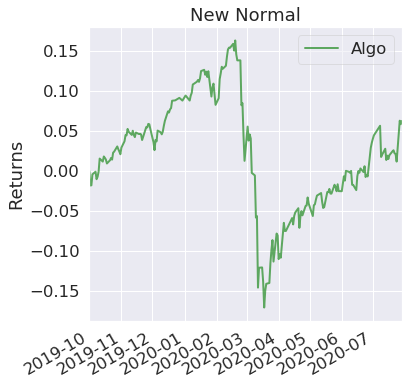

In [294]:
pf.create_interesting_times_tear_sheet(timereturn_df['return'])

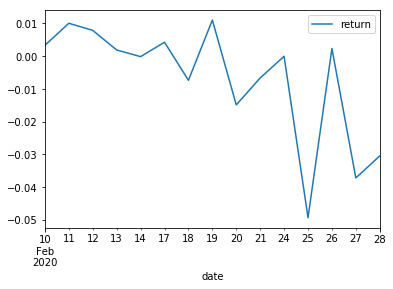

In [295]:
timereturn_df[(timereturn_df.index>'2020-02-07') & (timereturn_df.index<'2020-03-01')].plot()

In [296]:
timereturn_df.loc['2020-04-14']

return    0.014417
Name: 2020-04-14 00:00:00, dtype: float64

In [297]:
mypositions[(mypositions.index>'2020-02-05') & (mypositions.index<'2020-03-01')].head(10)

,bonds,japan,emerging_markets,pacific,nasdaq100,tech,china,stoxx,cash,total
Datetime,,,,,,,,,,
2020-02-06,177.535102,146.714171,892.627327,126.986850,962.413177,407.872951,151.249375,896.150753,10.659932,3772.209638
2020-02-07,177.873910,146.246928,882.102612,127.039740,967.134841,409.658734,149.789439,893.365680,10.659932,3763.871816
2020-02-10,178.212717,146.139103,886.049380,127.039740,972.432317,410.373048,150.957388,894.651098,10.659932,3776.514722
2020-02-11,178.212717,147.109530,898.218581,128.837971,982.105968,415.016085,154.169247,900.221244,10.659932,3814.551275
2020-02-12,177.873910,146.570404,910.058885,130.847758,987.403444,415.730398,156.505145,909.004935,10.659932,3844.654811
2020-02-13,177.873910,146.318811,907.098809,130.583313,994.428358,419.659122,155.921171,909.433408,10.659932,3851.976833
2020-02-14,178.212717,145.168676,906.769911,130.847758,995.349658,420.016279,155.921171,908.576462,10.659932,3851.522565
2020-02-17,178.212717,144.557666,912.690063,131.270872,999.495509,422.516376,157.673094,910.933062,10.659932,3868.009291
2020-02-18,178.212717,143.012172,900.520862,131.270872,994.198033,418.587652,155.629183,907.505280,10.659932,3839.596703


In [298]:
transactions[(transactions.index>'2020-04-01') & (transactions.index<'2020-05-01')].head(30)

,amount,price,sid,symbol,value
date,,,,,
2020-04-02 23:59:59.999989+00:00,6.781105,5.24,0,bonds,-35.532990
2020-04-02 23:59:59.999989+00:00,0.880347,32.29,1,japan,-28.426396
2020-04-02 23:59:59.999989+00:00,8.307763,20.53,2,emerging_markets,-170.558376
2020-04-02 23:59:59.999989+00:00,1.421320,17.50,3,pacific,-24.873096
2020-04-02 23:59:59.999989+00:00,2.526417,67.51,4,nasdaq100,-170.558382
2020-04-02 23:59:59.999989+00:00,7.958117,8.93,5,tech,-71.065985
2020-04-02 23:59:59.999989+00:00,6.087022,4.67,6,china,-28.426391
2020-04-02 23:59:59.999989+00:00,5.501883,31.00,7,stoxx,-170.558379


Start date,2019-10-01
End date,2020-07-29
Total months,9
,Backtest
Annual return,7.7%
Cumulative returns,6.3%
Annual volatility,24.2%
Sharpe ratio,0.43
Calmar ratio,0.27
Stability,0.11
Max drawdown,-28.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.72,2020-02-19,2020-03-18,NaT,NaN
1,3.89,2020-01-20,2020-01-31,2020-02-06,14
2,3.10,2019-11-27,2019-12-03,2019-12-13,13
3,1.80,2019-10-01,2019-10-02,2019-10-11,9
4,1.32,2019-11-07,2019-11-21,2019-11-25,13


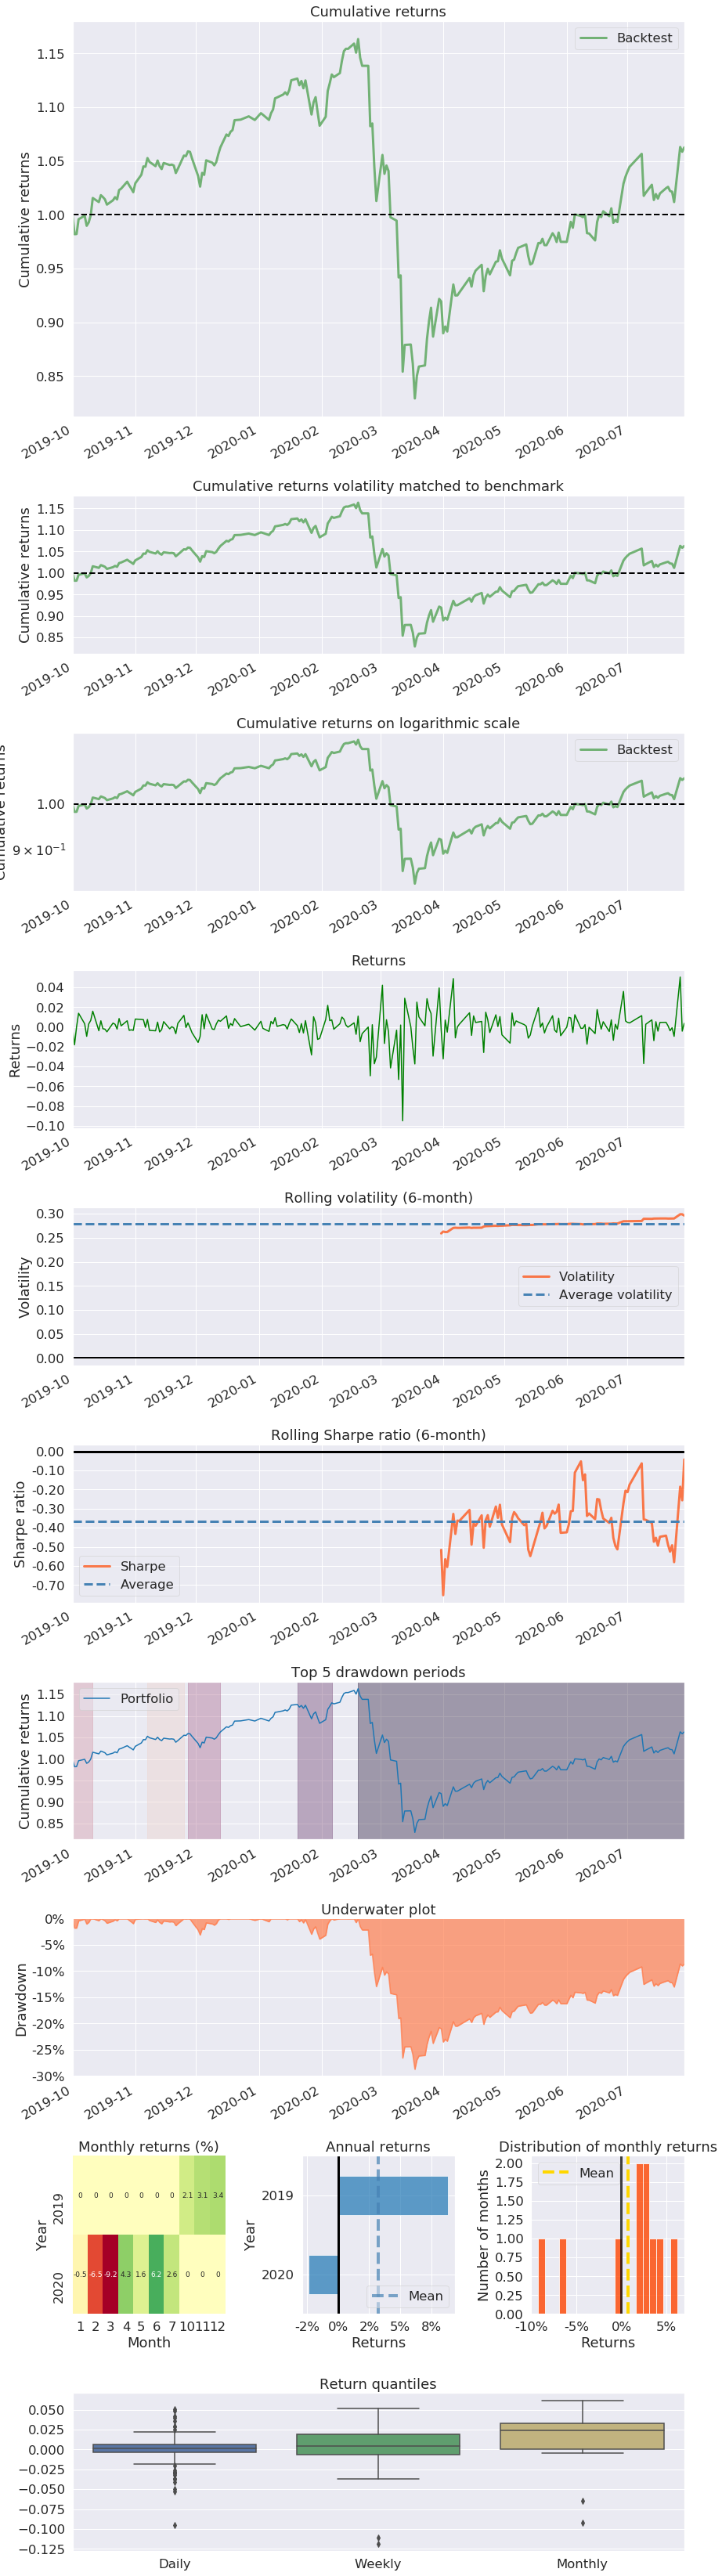

In [299]:
# plotting
figs=pf.create_returns_tear_sheet(timereturn_df['return'],return_fig=True)

In [272]:
timereturn_df.groupby(timereturn_df.index.month).head(10)
#ou can directly df.groupby(df.index.month)

,return
date,
2020-01-02,0.000000
2020-01-03,0.000478
2020-01-06,-0.004330
2020-01-07,0.005610
2020-01-08,0.003106
...,...
2020-07-13,0.006979
2020-07-14,-0.013211
2020-07-15,0.005407


In [273]:
#timereturn_df.groupby(pd.Grouper(freq='M')).cumsum()
timereturn_df.resample('M').sum()

,return
date,
2020-01-31,-0.007993
2020-02-29,-0.067104
2020-03-31,-0.083101
2020-04-30,0.044330
2020-05-31,0.015902
2020-06-30,0.058909
2020-07-31,0.027452


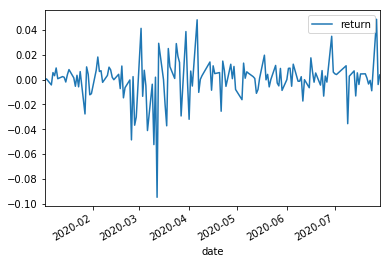

In [274]:
timereturn_df.plot()

In [256]:
mypositions[(mypositions.index>'2020-04-01') & (mypositions.index<'2020-05-01')]

,bonds,japan,emerging_markets,pacific,nasdaq100,tech,china,stoxx,cash,total
Datetime,,,,,,,,,,
2020-04-02,140.922699,100.240748,574.062500,83.960034,616.082428,251.728326,105.878781,564.996859,10.659936,2448.532311
2020-04-03,140.922699,99.063995,568.793328,82.936131,616.004056,251.728326,105.651573,560.053594,10.659936,2435.813638
2020-04-06,140.922699,99.063995,568.793328,82.936131,616.004056,251.728326,105.651573,581.291324,10.659936,2457.051368
2020-04-07,140.653763,107.084493,568.793328,82.936131,616.004056,251.728326,109.741311,592.276357,10.659936,2479.877702
2020-04-08,140.384827,105.319364,568.793328,82.936131,616.004056,251.728326,108.832480,594.473364,10.659936,2479.131812
2020-04-09,141.191636,106.217413,568.793328,82.936131,616.004056,251.728326,109.059688,601.430551,10.659936,2488.021065
2020-04-14,141.998445,107.239329,568.793328,82.936131,616.004056,251.728326,110.422934,606.007648,10.659936,2495.790134
2020-04-15,141.729509,106.372248,568.793328,82.936131,616.004056,251.728326,109.059688,586.051505,10.659936,2473.334727
2020-04-16,142.267382,106.527084,568.793328,82.936131,616.004056,251.728326,111.558973,590.628602,10.659936,2481.103818
